<a href="https://colab.research.google.com/github/Juanvr/NoteIdentifier/blob/main/Note_Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note Identifier

### Recording Audio in Colab

*Many thanks to: https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=-YilAhGr6gtZ*

In [2]:
!pip install ffmpeg-python

In [3]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [4]:
#audio, sr = get_audio()

We create a function that records audio and saves it to a file:

In [5]:
import scipy

def record_audio_to_file(file_name):
    display(HTML(AUDIO_HTML))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    
    process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
    )
    output, err = process.communicate(input=binary)
    
    riff_chunk_size = len(output) - 8
    # Break up the chunk size into four bytes, held in b.
    q = riff_chunk_size
    b = []
    for i in range(4):
        q, r = divmod(q, 256)
        b.append(r)

    # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
    riff = output[:4] + bytes(b) + output[8:]

    sr, audio = wav_read(io.BytesIO(riff))
    scipy.io.wavfile.write(file_name, sr, audio)

In [6]:
record_audio_to_file("recording.wav")

### Spectrum Analysis

*Many thanks to Allen Downey*



In [7]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2021-01-17 17:39:48--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2021-01-17 17:39:49--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.003s  

2021-01-17 17:39:49 (13.5 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [8]:
from thinkdsp import read_wave
from thinkdsp import decorate

wave = read_wave('recording.wav')

In [9]:
wave.make_audio()

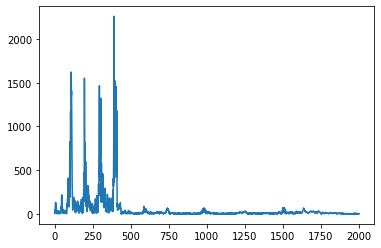

In [10]:
wave = read_wave('recording.wav')
spectrum = wave.make_spectrum()
spectrum.plot(high=2000)

In [11]:
spectrum.peaks()[0]

(2260.1369204613893, 390.97222222222223)

### Get notes frequencies table
*Many thanks to: https://pages.mtu.edu/~suits/notefreqs.html*

In [12]:
url = 'https://pages.mtu.edu/~suits/notefreqs.html'

In [13]:
import pandas as pd

In [14]:
tables = pd.read_html(url)

In [15]:
df_notes = tables[1]
df_notes.head()

,0,1,2
0,C0,16.35,2109.89
1,C#0/Db0,17.32,1991.47
2,D0,18.35,1879.69
3,D#0/Eb0,19.45,1774.20
4,E0,20.60,1674.62


In [16]:
df_notes.columns=["Note", "Frequency", "Wavelength"]
df_notes

,Note,Frequency,Wavelength
0,C0,16.35,2109.89
1,C#0/Db0,17.32,1991.47
2,D0,18.35,1879.69
3,D#0/Eb0,19.45,1774.20
4,E0,20.60,1674.62
...,...,...,...
103,G8,6271.93,5.50
104,G#8/Ab8,6644.88,5.19
105,A8,7040.00,4.90
106,A#8/Bb8,7458.62,4.63


In [17]:
freq = 130.21582733812951

In [18]:
def find_nearest(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lower_values = df[df[colname] < value][colname]
        lower_neighbour_value = lower_values.max()
        lower_neighbour_idx = lower_values.idxmax()
        upper_values = df[df[colname] > value][colname]
        upper_neighbour_value = upper_values.min()
        upper_neighbour_idx = upper_values.idxmin()
        
        distances = value - np.array((lower_neighbour_value, upper_neighbour_value))
        mask = distances == distances.min()
        closest_neighbour_idx = np.array((lower_neighbour_idx, upper_neighbour_idx))[mask]
        return closest_neighbour_idx[0]

In [19]:
closest_note = df_notes.loc[[find_nearest(freq, df_notes, "Frequency")]]
closest_note

,Note,Frequency,Wavelength
36,C3,130.81,263.74


### Wrapping up

In [76]:
record_audio_to_file("recording.wav")

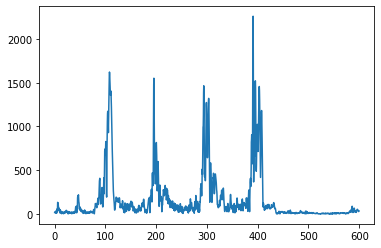

In [20]:
wave = read_wave('recording.wav')
spectrum = wave.make_spectrum()
spectrum.plot(high=600)

In [21]:
freq = spectrum.peaks()[0][1]

In [22]:
note = df_notes.loc[[find_nearest(freq, df_notes, "Frequency")]]
note

,Note,Frequency,Wavelength
55,G4,392.0,88.01


In [23]:
def name_note(freq, df_notes):
  return df_notes.loc[find_nearest(freq, df_notes, "Frequency")]["Note"]

### Chord identifying

In [24]:
freqs = spectrum.peaks()
freqs = freqs[:200]

In [25]:
df_peaks = pd.DataFrame(freqs, columns=["Amplitude", "Frequency"])
df_peaks.head()

,Amplitude,Frequency
0,2260.136920,390.972222
1,2126.585110,390.625000
2,1810.994874,391.319444
3,1622.126507,107.986111
4,1602.901206,108.333333


In [26]:
df_peaks["Note"] = df_peaks['Frequency'].apply(lambda f: name_note(f, df_notes))
df_peaks.head(20)

,Amplitude,Frequency,Note
0,2260.136920,390.972222,G4
1,2126.585110,390.625000,G4
2,1810.994874,391.319444,G4
3,1622.126507,107.986111,A2
4,1602.901206,108.333333,A2
5,1571.693315,107.638889,A2
6,1571.406767,390.277778,G4
7,1551.652689,195.486111,G3
8,1538.988823,108.680556,A2
9,1521.986047,395.486111,G#4/Ab4
